# Langevin Diffusion Model
[reference](https://www.peterholderrieth.com/blog/2023/Langevin-Dynamics-An-introduction-for-Machine-Learning-Engineers/) 

<Axes: >

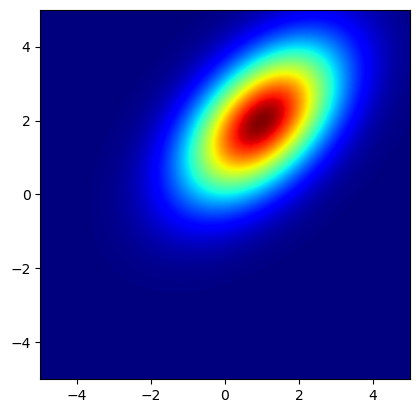

In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt
from typing import List, Callable
from itertools import product

def plot_density(density_func: Callable, fpath: str = None, min_x: float = -5.0, max_x: float = 5.0, n_grid_points: int = 50, plot_contours: bool = False, my_axis=None, **kwargs):
    oned_grid = np.linspace(min_x, max_x, n_grid_points)
    twod_grid = np.array([[x,y] for x,y in product(oned_grid,oned_grid)])
    extent = [oned_grid.min(), oned_grid.max(), oned_grid.min(), oned_grid.max()]
    result = density_func(x=twod_grid, **kwargs)
    if my_axis is None:
        fig, my_axis = plt.subplots()
    my_axis.imshow(result.reshape(n_grid_points,n_grid_points).transpose(),interpolation='bilinear',origin='lower', extent = extent, cmap=plt.get_cmap('jet'))
    if plot_contours:
        my_axis.contour(result.reshape(n_grid_points,n_grid_points).transpose(),interpolation='bilinear',origin='lower', extent = extent,color='black')
    if fpath is not None:
        plt.savefig(fpath)
    return my_axis

def get_gaussian(func_type: str, x: np.array, mean: np.array = None, cov: np.array = None):
    n = x.shape[0]
    k = x.shape[1]
    if mean is not None:
        assert len(mean) == k
        x = x - mean[None, :]
    if cov is None:
        cov = np.eye(k)
    else:
        assert cov.shape == (k, k)
    inv_cov = np.linalg.inv(cov)
    quadratic_product = (x * np.dot(x, inv_cov)).sum(axis=1)
    denominator = math.sqrt(((2*np.pi)**k)*np.linalg.det(cov))
    if func_type == 'density':
        return np.exp(-0.5 * quadratic_product)/denominator
    elif func_type == 'log_density':
        return -0.5*quadratic_product - np.log(denominator)
    elif func_type == 'gradient_of_density':
        return -np.dot(x, inv_cov) * np.exp(-0.5 * quadratic_product[:, None]) / denominator
    elif func_type == 'score':
        return -np.dot(x, inv_cov)

plot_density(density_func=get_gaussian, func_type='density', mean=np.array([1,2]), cov=np.array([[2,1],[1,2]]))

<Axes: >

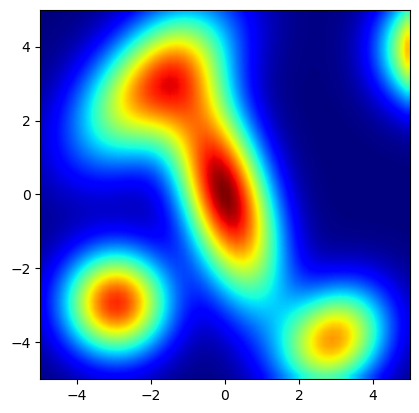

In [69]:
# def gaussian_density(x: np.array, mean: np.array, cov: np.array):
#     return get_gaussian(func_type='density', x=x, mean=mean, cov=cov)

def get_gaussian_mixture(func_type: str, x: np.array, mean_list: list[np.array], cov_list: list[np.array], mixture_probs: np.array = None):
    N = len(mean_list)
    if cov_list is None:
        cov_list = N * [None]
    if mixture_probs is None:
        mixture_probs = np.ones(N)/N
    if func_type == 'density':
        density = np.zeros(len(x))
        for mean, cov, prob in zip(mean_list, cov_list, mixture_probs):
            density += prob * get_gaussian(func_type='density', x=x, mean=mean, cov=cov)
        return density
    elif func_type == 'score':
        score = np.zeros(shape=(len(x),x.shape[1]))
        for mean, cov, prob in zip(mean_list, cov_list, mixture_probs):
            score += prob * get_gaussian(func_type="gradient_of_density", x=x, mean=mean, cov=cov)
        density = get_gaussian_mixture('density', x, mean_list, cov_list, mixture_probs)
        score = score / density[:,None]
        return score

def gaussian_mixture_density(**kwargs):
    """Function to get density of a Gaussian mixture distribution."""
    return get_gaussian_mixture(func_type="density", **kwargs)

def gaussian_mixture_score(**kwargs):
    """Function to get the score of a Gaussian mixture distribution."""
    return get_gaussian_mixture(func_type="score", **kwargs)

def plot_gaussian_mixture_density(**kwargs):
    """Function to plot a Gaussian mixture density."""
    return plot_density(gaussian_mixture_density,**kwargs)

MEAN_LIST = [np.array([-2,3]), np.array([0,0]), np.array([3,-4]), np.array([-3,-3]), np.array([6,4])]
COV_LIST = [np.array([[2,1],[1,2]]), np.array([[1,-1],[-1,4]]), np.array([[1,0.2],[0.2,1.0]]), np.eye(2), np.eye(2)]
MIXTURE_PROBS = [0.225, 0.3, 0.125, 0.15, 0.20]

kwargs = {
    'mean_list': MEAN_LIST,
    'cov_list': COV_LIST,
    'mixture_probs': MIXTURE_PROBS
}


# plot_density(get_gaussian_mixture, func_type='density', mean_list=MEAN_LIST, cov_list=COV_LIST, mixture_probs=MIXTURE_PROBS)
plot_gaussian_mixture_density(**kwargs)

Langevin SDE

The Langevin Stochastic Differential Equation
$$dX_t=\nabla \log p(X_t) + \sqrt{2}W_t$$

<Axes: >

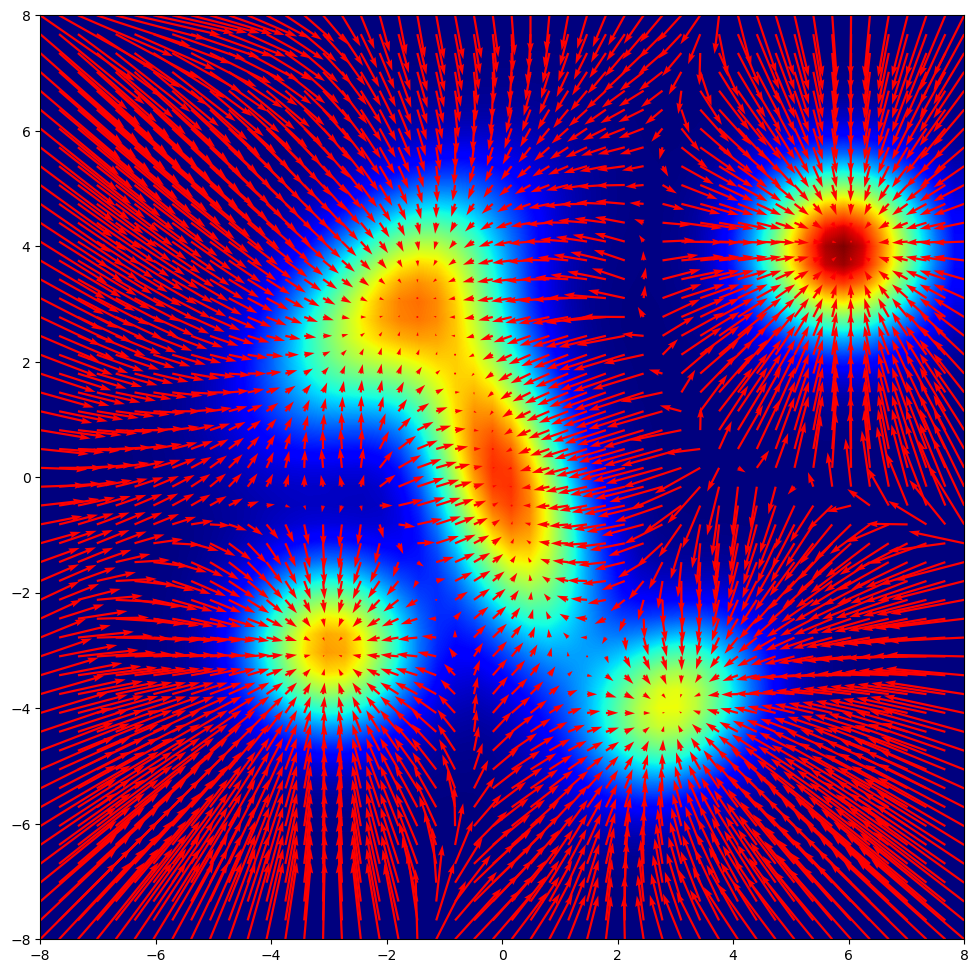

In [71]:
def plot_score_vector_field(score_func: Callable, density_func: Callable, fpath: str = None, min_x: float = -5.0, max_x: float = 5.0, n_grid_points: int = 50, plot_contours: bool = False, **kwargs):
    oned_grid = np.linspace(min_x, max_x, n_grid_points)
    twod_grid = np.array([[x,y] for x,y in product(oned_grid,oned_grid)])
    extent = [oned_grid.min(), oned_grid.max(), oned_grid.min(), oned_grid.max()]
    result = density_func(x=twod_grid,**kwargs)
    score = score_func(x=twod_grid,**kwargs)

    fig,my_axis = plt.subplots(figsize=(12,12))
    my_axis.imshow(result.reshape(n_grid_points,n_grid_points).transpose(),interpolation='bilinear',origin='lower', extent = extent, cmap=plt.get_cmap('jet'))
    if plot_contours:
        my_axis.contour(result.reshape(n_grid_points,n_grid_points).transpose(),interpolation='bilinear',origin='lower', extent = extent, color='black')
    if fpath is not None:
        plt.savefig(fpath)
    
    my_axis.quiver(twod_grid[:,0],twod_grid[:,1],score[:,0],score[:,1], scale=60.0, color='r')
    return my_axis

plot_score_vector_field(score_func=gaussian_mixture_score, density_func=gaussian_mixture_density, min_x=-8, max_x=8, **kwargs)

In [86]:
def langevin_diffusion(x_start: np.array, score_func: Callable, dt: float, n_step: int, **kwargs):
    n = x_start.shape[0]
    d = x_start.shape[1]
    x_traj = [x_start]
    for i in range(n_step):
        score = score_func(x=x_start, **kwargs)
        xi = np.random.randn(n, d)
        x_start = x_start + dt * score + np.sqrt(2 * dt) * xi
        x_traj.append(x_start)
    return np.stack(x_traj)

x_start = np.array([[1, 2]]); dt = 0.4; n_step = 10000
x_traj = langevin_diffusion(x_start=x_start, score_func=gaussian_mixture_score, dt=dt, n_step=n_step, **kwargs).squeeze()


Text(0.5, 1.0, 'Trajectory of Langevin diffusion up to 10000')

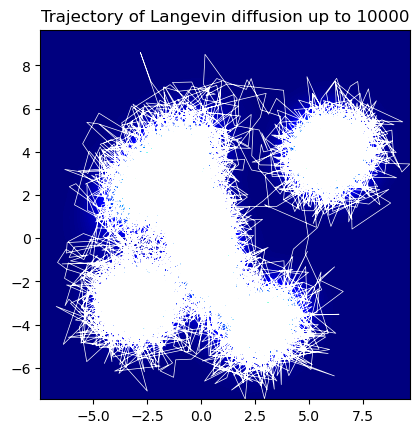

In [87]:
ax = plot_gaussian_mixture_density(min_x=min(x_traj[:,0].min(),x_traj[:,1].min()), max_x=max(x_traj[:,0].max(),x_traj[:,1].max()), **kwargs)
ax.plot(x_traj[:,0], x_traj[:,1], color='w', alpha=1.0, linewidth=0.5)
ax.set_title(f"Trajectory of Langevin diffusion up to {n_step}")